In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:

def split_dataset():
    A_train = np.empty((10304, 0))
    A_test = np.empty((10304, 0))
    
    try:
        for i in range(1, 41):
            for j in range(1, 9):
                path = f'C:/Users/Administrator/Desktop/ASC/att_faces/s{i}/{j}.pgm'
                poza = cv2.imread(path, 0)
                if poza is None:
                    raise FileNotFoundError(f"Could not read image: {path}")
                poza = poza.flatten()[:, np.newaxis]
                A_train = np.hstack((A_train, poza))
            
            for j in range(9, 11):
                path = f'C:/Users/Administrator/Desktop/ASC/att_faces/s{i}/{j}.pgm'
                poza = cv2.imread(path, 0)
                if poza is None:
                    raise FileNotFoundError(f"Could not read image: {path}")
                poza = poza.flatten()[:, np.newaxis]
                A_test = np.hstack((A_test, poza))
        
        return A_train, A_test
    except Exception as e:
        print(f"Error in split_dataset: {e}")
        return None

In [3]:
def norma_1(x):
    return np.linalg.norm(x, 1)

def norma_2(x):
    return np.linalg.norm(x, 2)

def norma_inf(x):
    return np.linalg.norm(x, np.inf)

def cosine_norm(x, y):
    return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

norms = {
    '1': norma_1,
    '2': norma_2,
    'inf': norma_inf,
    'cosine': cosine_norm
}

In [4]:
def NN(A_train, test_image, norma):
    distances = []
    
    for i in range(A_train.shape[1]):
        train_image = A_train[:, i]
        
        if norma == cosine_norm:
            distance = norma(test_image, train_image)
        else:
            distance = norma(train_image - test_image)
        
        distances.append((distance, i))
    
    min_idx = np.argmin([dist[0] for dist in distances])
    predicted_person, predicted_image_idx = distances[min_idx][1]//8, distances[min_idx][1]
    
    return predicted_person, A_train[:, predicted_image_idx]

In [5]:
# Function to calculate accuracy
def calculate_accuracy(A_train, A_test, norms, norm_type='2'):
    correct_predictions = 0
    total_tests = A_test.shape[1]
    
    selected_norm = norms[norm_type]
    
    for test_idx in range(total_tests):
        actual_person = test_idx // 2
        test_image = A_test[:, test_idx]

        predicted_person, predicted_image_idx = NN(A_train, test_image, norma=selected_norm)

        if predicted_person == actual_person:
            correct_predictions += 1
    
    accuracy = (correct_predictions / total_tests) * 100
    return accuracy


In [6]:
norm_choice = input("Enter the norm you want to use ('1', '2', 'inf', 'cosine'): ")

if norm_choice not in norms:
    print("Invalid norm choice! Please choose from '1', '2', 'inf', or 'cosine'.")
else:
    A_train, A_test = split_dataset()
    accuracy = calculate_accuracy(A_train, A_test, norms, norm_type=norm_choice)
    print(f"Accuracy of Nearest Neighbor classifier ({norm_choice} norm): {accuracy:.2f}%")

Accuracy of Nearest Neighbor classifier (2 norm): 95.00%


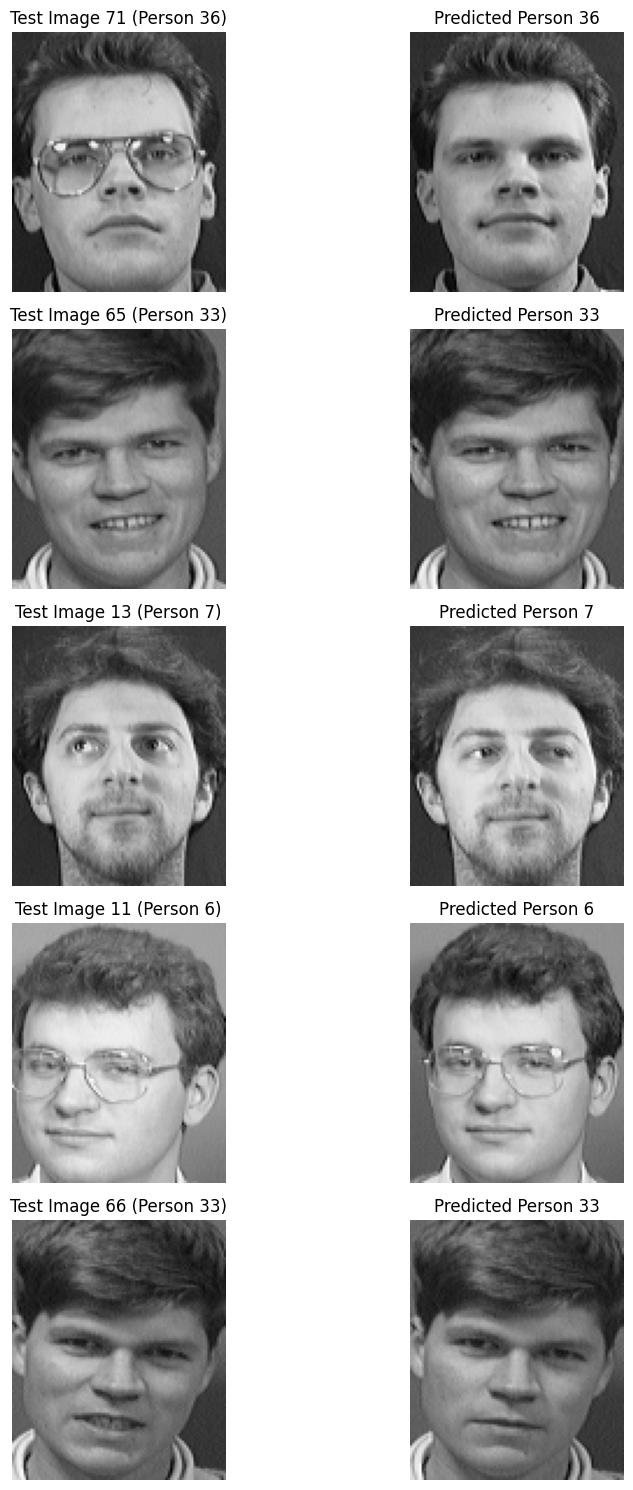

Accuracy for 5 test images using 2 norm: 100.00%


In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

def test_predictions(A_train, A_test, norms, norm_type='2', num_images=5):
    correct_predictions = 0
    test_indices = random.sample(range(A_test.shape[1]), num_images)
    
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i, test_idx in enumerate(test_indices):
        actual_person = test_idx // 2
        
        test_image = A_test[:, test_idx]
        predicted_person, predicted_image = NN(A_train, test_image, norma=norms[norm_type])
        
        ax1, ax2 = axes[i]
        ax1.imshow(test_image.reshape(112, 92), cmap='gray')
        ax1.set_title(f'Test Image {test_idx + 1} (Person {actual_person + 1})')
        ax1.axis('off')
        
        ax2.imshow(predicted_image.reshape(112, 92), cmap='gray')
        ax2.set_title(f'Predicted Person {predicted_person + 1}')
        ax2.axis('off')
        
        if predicted_person == actual_person:
            correct_predictions += 1
    
    plt.tight_layout()
    plt.show()

    accuracy = correct_predictions / num_images * 100
    print(f"Accuracy for {num_images} test images using {norm_type} norm: {accuracy:.2f}%")
    
test_predictions(A_train, A_test, norms, norm_type='2', num_images=5)


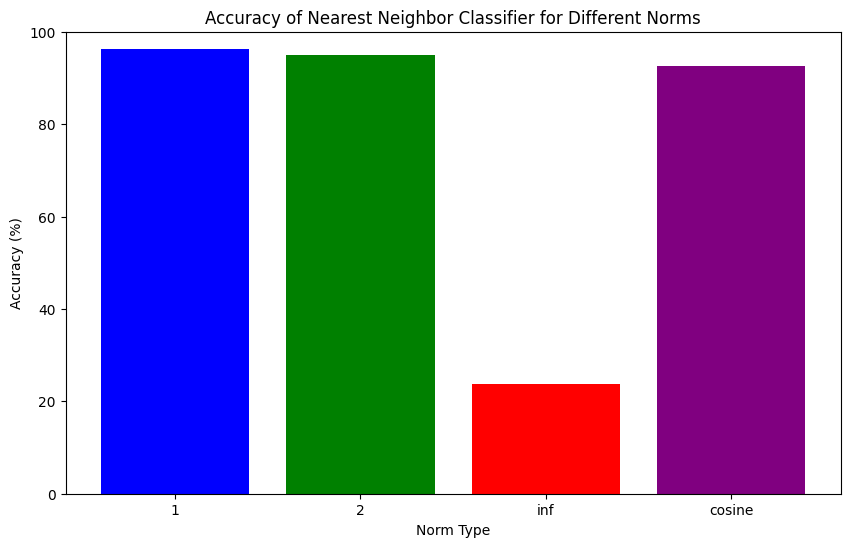

In [43]:
import matplotlib.pyplot as plt

def plot_accuracy_for_norms(A_train, A_test, norms):
    accuracy_results = {}
    
    for norm_name, norm_func in norms.items():
        accuracy = calculate_accuracy(A_train, A_test, norms, norm_type=norm_name)
        accuracy_results[norm_name] = accuracy
    
    norm_names = list(accuracy_results.keys())
    accuracies = list(accuracy_results.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(norm_names, accuracies, color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Norm Type')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy of Nearest Neighbor Classifier for Different Norms')
    plt.ylim([0, 100])
    plt.show()

plot_accuracy_for_norms(A_train, A_test, norms)